# A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal

This notebook reproduces results of the Bruegel Working Paper "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023).

For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".

For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import time
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from scipy.optimize import minimize_scalar
from numba import jit
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from EcDsaModelClass import EcDsaModel
from EcStochasticModelClass import EcStochasticModel

# Set autoreleoad
%load_ext autoreload
%autoreload 2

## Example Cases
This section introduces some functionalities of the EcDsaModelClass and the EcStochasticModelClass

### Deterministic Model Class

Initialize model with country ISO code and adjustment period length. For deterministic projections we can use the parent class *EcDsaModel*.

In [2]:
bel_dsa_model = EcDsaModel(country='BEL', adjustment_period=4, end_year=2038)

Project the debt ratio forward, assuming linear adjustment to structural primary balance target using the *project* method. \
To project the model under specific scenario assumptions, pass the scenario name as a string.

In [3]:
bel_dsa_model.project(spb_target=1, scenario=None)

Show the resulting debt ratio and primary balance path using the *df* method. \
The method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe.

In [4]:
output_var_dict = {'d': 'Debt ratio', 'spb_bcoa': 'Ageing-cost adjusted structural primary balance', 'pb': 'Primary balance', 'fb':'Overall balance'}
output_df = bel_dsa_model.df(output_var_dict)
output_df.head(10)

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance
t,y,,,,
0,2022,105.129,-2.655,-2.365,NaN
1,2023,105.670,-3.138,-3.254,-4.690
2,2024,107.029,-2.504,-2.753,-4.725
3,2025,107.948,-1.628,-2.098,-4.363
4,2026,108.412,-0.752,-1.460,-3.961
5,2027,108.105,0.124,-0.688,-3.380
6,2028,107.009,1.000,0.187,-2.652
7,2029,105.159,1.000,0.426,-2.495
8,2030,103.471,1.000,0.656,-2.334


The *find_spb_deterministic* method finds the structural primary balance path so that specified criteria are met given scenario assumptions.

In [5]:
bel_dsa_model.find_spb_deterministic(scenario='adverse_r_g', criterion='debt_decline')

1.8892999999998326

The model is upodated automatically to the optimal SPB and we can plot the resulting debt ratio projection using the *df* method and build-in plotting function.

<Axes: title={'center': 'Debt ratio projection Belgium'}, xlabel='(t, Year)', ylabel='Debt ratio'>

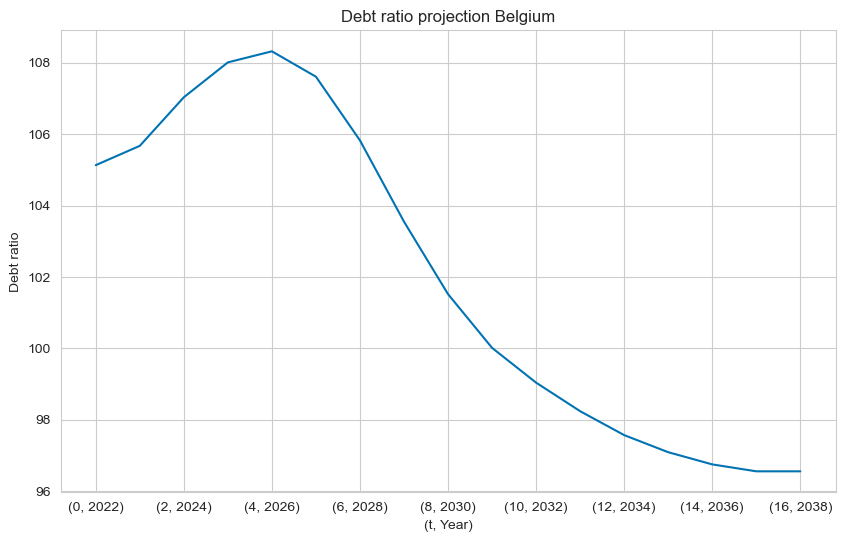

In [6]:
bel_dsa_model.df('d').plot(title='Debt ratio projection Belgium', ylabel='Debt ratio', xlabel='(t, Year)', legend=False, figsize=(10, 6))

### Stochastic Model Class

The *StochasticModelClass* is a subclass of the *EcDsaModel* and inherits all its functionalities. It is initiated analogously.

In [7]:
esp_dsa_stochastic_model = EcStochasticModel(country='ESP', adjustment_period=7, end_year=2041)

After projecting the debt path, the *simulate* method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [8]:
esp_dsa_stochastic_model.project()
esp_dsa_stochastic_model.simulate(N=10000)

The *find_spb_stochastic* method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing.

In [9]:
esp_dsa_stochastic_model.find_spb_stochastic(prob_target=0.3)

1.8835894559069264

The *fanchart* method plots the percentiles of the simulated distribution of the debt ratio.

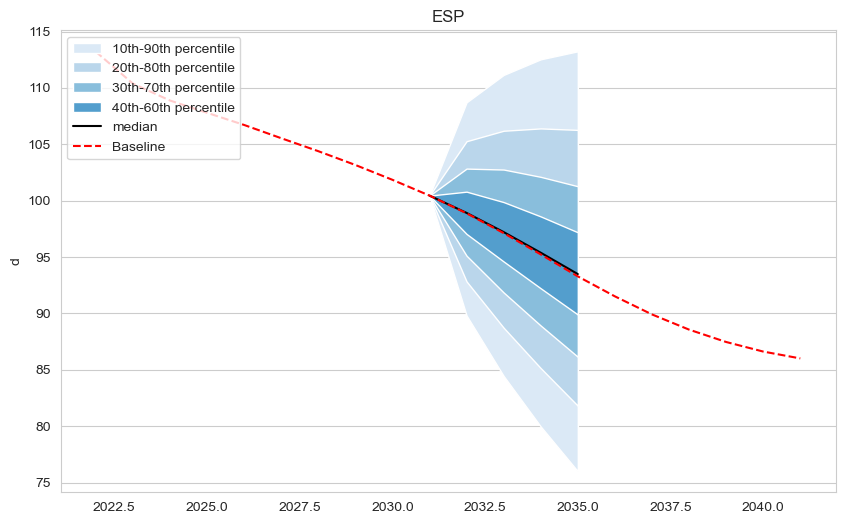

In [12]:
esp_dsa_stochastic_model.fanchart(variable='d')

The *find_spb_deficit* method optimizes for the structural primary balance that ensures a decline in the debt ratio after reaching a deficit below 3%.

In [13]:
esp_dsa_stochastic_model.find_spb_deficit()

Deficit periods: 3
Final spb_deficit_step 0.5
ESP spb target: {'main_adjustment': 1.3029999999998327, 'lower_spb': 1.795299999999833, 'financial_stress': 1.3034999999998327, 'adverse_r_g': 2.07489999999982, 'deficit_reduction': 1.5206999999998332, 'debt_safeguard': 0.3462999999998317, 'stochastic': 1.8769789610806316}


2.07489999999982

In [32]:
output_df = esp_dsa_stochastic_model.df(output_var_dict).loc[1:10]
output_df['Annual adjustment'] = output_df['Ageing-cost adjusted structural primary balance'].diff()
output_df

,,Debt ratio,Ageing-cost adjusted structural primary balance,Primary balance,Overall balance,Annual adjustment
t,y,,,,,
1,2023,110.390,-1.229,-1.589,-3.907,NaN
2,2024,108.885,-0.767,-0.885,-3.317,0.462
3,2025,107.819,-0.267,-0.571,-3.253,0.500
4,2026,106.639,0.233,-0.183,-3.058,0.500
5,2027,105.221,0.733,0.279,-2.750,0.500
6,2028,103.626,1.037,0.669,-2.479,0.304
7,2029,102.028,1.340,1.029,-2.213,0.304
8,2030,100.434,1.644,1.360,-1.956,0.304
9,2031,98.880,1.947,1.662,-1.713,0.304


The *find_deficit_prob* method builds on the stochastic dsa model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
It requires the specification of an adjustment path by passing aa structural primary balance target, and optionally, the number and step size of initial periods under deficit procedure. 

In [15]:
esp_dsa_stochastic_model.find_deficit_prob(spb_target=1.9473, spb_deficit_period=3, spb_deficit_step=0.5)

array([0.50021 , 0.472875, 0.431905, 0.396895, 0.36468 , 0.3356  ,
       0.30893 ])

## Define variables and functions

In [16]:
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

eu_code_dict = {
    'BEL' : 'Belgium',
    'DEU' : 'Germany',
    'DNK' : 'Denmark',
    'GRC' : 'Greece',
    'ESP' : 'Spain',
    'FRA' : 'France',
    'IRL' : 'Ireland',
    'ITA' : 'Italy',
    'NLD' : 'Netherlands',
    'AUT' : 'Austria',
    'PRT' : 'Portugal',
    'FIN' : 'Finland',
    'SWE' : 'Sweden',
    'CZE' : 'Czech Republic',
    'HUN' : 'Hungary',
    'POL' : 'Poland',
    'SVK' : 'Slovakia',
    'SVN' : 'Slovenia',
    'CYP' : 'Cyprus',
    'MLT' : 'Malta',
    'BGR' : 'Bulgaria',
    'ROU' : 'Romania',
    'HRV' : 'Croatia'
    }

eu_codes = list(eu_code_dict.keys())

var_list = [
    'rg',
    'rg_pot',
    'ng',
    'output_gap',
    'pi',
    'rgdp_pot',
    'rgdp',
    'ngdp',
    'i_st',
    'i_lt',
    'iir_lt',
    'iir_lt_inst',
    'iir',
    'sf',
    'ageing_cost',
    'ageing_component',
    'cyclical_component',
    'spb_bcoa',
    'pb',
    'pb_cyclical_adj',
    'pb_cyclical_ageing_adj',
    'fb',
    'fb_alt',
    'd',
    'd_alt',
    'D',
    'D_lt_inst',
    'D_st',
    'D_lt',
    'amortization',
    'amortization_lt',
    'amortization_lt_inst'
    ]

# Set path
if not os.path.exists(f'../output/{today}'):
    os.makedirs(f'../output/{today}')
if not os.path.exists(f'../output/{today}/fancharts'):
    os.makedirs(f'../output/{today}/fancharts') 
if not os.path.exists(f'../output/{today}/results_charts'):
    os.makedirs(f'../output/{today}/results_charts')       
output_path = f'../output/{today}'

In [17]:
# Define function to run deterministic criteria scenarios
def run_deterministic_scenario(country, adjustment_period, scenario=None, criterion=None, scenario_name='scenario'):
    try:
        dsa = EcDsaModel(country=country, adjustment_period=adjustment_period)
        if adjustment_period == 'nfpc':
            dsa.project() # NFPC is not optimized
            adjustment_period = 4 # Set a 4 years dict key for NFPC
        else:
            dsa.find_spb_deterministic(scenario=scenario, criterion=criterion)
        df = dsa.df(var_list)
        results_dict[country][adjustment_period][scenario_name] = {}
        results_dict[country][adjustment_period][scenario_name]['df'] = df
        results_dict[country][adjustment_period][scenario_name]['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
        results_dict[country][adjustment_period][scenario_name]['fb'] = dsa.fb[dsa.adjustment_end]
        results_dict[country][adjustment_period][scenario_name]['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
        results_dict[country][adjustment_period][scenario_name]['high_deficit'] = np.any(dsa.fb[dsa.adjustment_start:dsa.adjustment_end+1] < -3)
        results_dict[country][adjustment_period][scenario_name]['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_end] - dsa.spb_bcoa[dsa.adjustment_end-1]
    except:
        pass

## Run scenario analysis

In [18]:
# Initialize results dictionary
results_dict = {}
for country in eu_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

### Find optimal structural primary balances for deterministic scenarios

In [19]:
start_time = time.time()
total_countries = len(eu_codes)
for counter, country in enumerate(eu_codes):
    counter += 1
    elapsed_time = time.time() - start_time
    estimated_remaining_time = round((elapsed_time / counter) * (total_countries - counter) / 60, 1)
    print(f'{counter} of {total_countries} - Estimated remaining time: {estimated_remaining_time} minutes', end='\r')

    for adjustment_period in [4, 7]:
        
        # NFPC scenario
        if adjustment_period == 4:
            run_deterministic_scenario(
                country=country, 
                adjustment_period='nfpc', 
                scenario=None, 
                criterion=None,
                scenario_name='nfpc'
                )

        # Main_adjustment and adverse scenarios
        for scenario in ['main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb']:
            run_deterministic_scenario(
                country=country, 
                adjustment_period=adjustment_period, 
                scenario=scenario, 
                criterion='debt_decline', 
                scenario_name=scenario
                )

        # Main_adjustment with deficit/expenditure/debt criteria
        for criterion in ['deficit_reduction', 'expenditure_safeguard', 'debt_safeguard']:
            if criterion == 'debt_safeguard' and adjustment_period == 7:
                continue
            else:
                run_deterministic_scenario(
                    country=country, 
                    adjustment_period=adjustment_period, 
                    scenario='main_adjustment', 
                    criterion=criterion, 
                    scenario_name=criterion
                    )

    # Set nfpc and debt safeguard 7 year results equal to 4 year results
    for scenario in ['nfpc', 'debt_safeguard']:
        if scenario in results_dict[country][4].keys():
            results_dict[country][7][scenario] = {}
            for key in results_dict[country][4][scenario].keys():
                results_dict[country][7][scenario][key] = results_dict[country][4][scenario][key]


### Find optimal structural primary balances for stochastic scenarios

In [20]:
start_time = time.time()
for counter, country in enumerate(eu_codes):
    
    counter += 1
    elapsed_time = time.time() - start_time
    estimated_remaining_time = round((elapsed_time / counter) * (total_countries - counter) / 60, 1)
    print(f'{counter} of {total_countries} - Estimated remaining time: {estimated_remaining_time} minutes', end='\r')

    for adjustment_period in [4, 7]:
        try:
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.find_spb_stochastic()
            df = dsa.df(var_list)
            dsa.fanchart(save_as=f'{output_path}/fancharts/fanchart_{country}_{adjustment_period}_{today}.jpeg', save_df=True, show=False)
            results_dict[country][adjustment_period]['stochastic'] = {}
            results_dict[country][adjustment_period]['stochastic']['df'] = df
            results_dict[country][adjustment_period]['stochastic']['df_fanchart'] = dsa.df_fanchart
            results_dict[country][adjustment_period]['stochastic']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
            results_dict[country][adjustment_period]['stochastic']['fb'] = dsa.fb[dsa.adjustment_end]
            results_dict[country][adjustment_period]['stochastic']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
            results_dict[country][adjustment_period]['stochastic']['high_deficit'] = np.any(dsa.fb[dsa.adjustment_start:dsa.adjustment_end+1] < -3)
            results_dict[country][adjustment_period]['stochastic']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_end] - dsa.spb_bcoa[dsa.adjustment_end-1]
        except:
            pass

### Find optimal structural primary balances for binding deficit safeguard scenarios

In [21]:
for country, adjustment_period_dict in results_dict.items():
    for adjustment_period, scenario_dict in adjustment_period_dict.items():

        # Find max spbstar for adjustment period
        max_spbstar = - np.inf
        max_spbstar_key = None
        for scenario, variable_dict in scenario_dict.items():
            if scenario in [
                'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb',  'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard', 'stochastic'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_value = variable_dict['spbstar']
                if spbstar_value > max_spbstar:
                    max_spbstar = spbstar_value
                    max_spbstar_key = (country, adjustment_period, max_spbstar, scenario)
        
        # Check if toughest scenario has excessive deficit and low adjustment
        if max_spbstar_key is not None:
            country, adjustment_period, max_spbstar, scenario = max_spbstar_key
            high_deficit = results_dict[country][adjustment_period][scenario]['high_deficit']
            annual_adjustment = results_dict[country][adjustment_period][scenario]['annual_adjustment']
            if high_deficit and (annual_adjustment < 0.5):

                # Find optimal spbstar with deficit procedure
                print('Calculating optimal spb for', country, adjustment_period, max_spbstar, 'from', scenario)
                dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
                dsa.find_spb_deficit()
                df = dsa.df(var_list)

                # Save results
                results_dict[country][adjustment_period]['deficit_safeguard'] = {}
                results_dict[country][adjustment_period]['deficit_safeguard']['df'] = df
                results_dict[country][adjustment_period]['deficit_safeguard']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
                results_dict[country][adjustment_period]['deficit_safeguard']['fb'] = dsa.fb[dsa.adjustment_end]
                results_dict[country][adjustment_period]['deficit_safeguard']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
                results_dict[country][adjustment_period]['deficit_safeguard']['high_deficit'] = np.any(dsa.fb[dsa.adjustment_start:dsa.adjustment_end+11] < -3)
                results_dict[country][adjustment_period]['deficit_safeguard']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_end] - dsa.spb_bcoa[dsa.adjustment_end-1]
                results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_period'] = dsa.spb_deficit_period
                results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_step'] = dsa.spb_deficit_step

Calculating optimal spb for ESP 7 1.9369999999998333 from adverse_r_g
Deficit periods: 3
Final spb_deficit_step 0.5
ESP spb target: {'main_adjustment': 1.1353999999998323, 'lower_spb': 1.6309999999998332, 'financial_stress': 1.1356999999998323, 'adverse_r_g': 1.9241999999998332, 'deficit_reduction': 1.391699999999833, 'debt_safeguard': 0.3462999999998317, 'stochastic': 1.8564961649243934}
Calculating optimal spb for ITA 7 2.674199999999806 from deficit_reduction
Deficit periods: 6
Final spb_deficit_step 0.5
ITA spb target: {'main_adjustment': 1.7192999999998324, 'lower_spb': 1.946499999999833, 'financial_stress': 2.0056999999998233, 'adverse_r_g': 2.4752999999998124, 'deficit_reduction': 2.6191999999998177, 'debt_safeguard': 2.04449999999982}
Calculating optimal spb for HUN 7 3.7218215051121706 from stochastic
Deficit periods: 4
Final spb_deficit_step 0.5
HUN spb target: {'main_adjustment': 2.7883999999998124, 'lower_spb': 3.143799999999795, 'financial_stress': 2.7928999999998005, 'adv

### Run scenarios with baseline assumptions and highest strucutral primary balance

In [22]:
for country, adjustment_period_dict in results_dict.items():
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        max_spbstar = - np.inf
        max_spbstar_key = None
        for scenario, variable_dict in scenario_dict.items():
            if scenario in [
                'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'stochastic', 'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard'
                ] and 'spbstar' in variable_dict.keys():
                spbstar_value = variable_dict['spbstar']
                if spbstar_value > max_spbstar:
                    max_spbstar = spbstar_value
                    max_spbstar_key = (country, adjustment_period, max_spbstar, scenario)
        
        # Run baseline scenario with max spbstar
        if max_spbstar_key is not None:
            country, adjustment_period, max_spbstar, scenario = max_spbstar_key

            if scenario == 'debt_safeguard':
                dsa = EcDsaModel(country=country, adjustment_period=4)
            else:
                dsa = EcDsaModel(country=country, adjustment_period=adjustment_period)
            dsa.project(spb_target=max_spbstar)
            df = dsa.df(var_list)

            results_dict[country][adjustment_period]['baseline_binding_spbstar'] = {}
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['df'] = df
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['spbstar'] = dsa.spb_bcoa[dsa.adjustment_end]
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['fb'] = dsa.fb[dsa.adjustment_end]
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['d_T+A+10'] = dsa.d[dsa.adjustment_end+10]
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['high_deficit'] = np.any(dsa.fb[dsa.adjustment_start:dsa.adjustment_end+10] < -3)
            results_dict[country][adjustment_period]['baseline_binding_spbstar']['annual_adjustment'] = dsa.spb_bcoa[dsa.adjustment_end] - dsa.spb_bcoa[dsa.adjustment_end-1]

### Find the probability of excessive deficit during the adjustment period

In [23]:
# Initialize deficit_prob_dict
deficit_prob_dict = {}

# Get df of binding scenario
for country, adjustment_period_dict in results_dict.items():
    deficit_prob_dict[country] = {}
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        deficit_prob_dict[country][adjustment_period] = {}
        try:
            if 'deficit_safeguard' in scenario_dict.keys():
                # Set parameters
                spbstar = results_dict[country][adjustment_period]['deficit_safeguard']['spbstar']
                spb_deficit_period = results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_period']
                spb_deficit_step = results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_step']
            
            else:
                # Set deficit parameters to baseline
                spbstar = results_dict[country][adjustment_period]['baseline_binding_spbstar']['spbstar']
                spb_deficit_period = 0
                spb_deficit_step = 0.5

            # Find probability of excessive deficit
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.find_deficit_prob(spb_target=spbstar, spb_deficit_period=spb_deficit_period, spb_deficit_step=spb_deficit_step)
            deficit_prob_dict[country][adjustment_period]['deficit_prob'] = dsa.prob_deficit
        except:
            deficit_prob_dict[country][adjustment_period]['deficit_prob'] = np.full(adjustment_period, np.nan)
            

## Save results to output folder

In [24]:
# Save deficit probability results
columns_4 = ['Country'] + [str(2025 + i) for i in range(4)]
columns_7 = ['Country'] + [str(2025 + i) for i in range(7)]

data_4 = []
data_7 = []

for country, values in deficit_prob_dict.items():
    row_4 = [country] + list(values.get(4, {'deficit_prob': []})['deficit_prob'])
    row_7 = [country] + list(values.get(7, {'deficit_prob': []})['deficit_prob'])
    data_4.append(row_4)
    data_7.append(row_7)

df_4 = pd.DataFrame(data_4, columns=columns_4)
df_7 = pd.DataFrame(data_7, columns=columns_7)

# Create an Excel writer
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_prob_deficit_{today}.xlsx') as writer:
    df_4.to_excel(writer, sheet_name='4-year', index=False)
    df_7.to_excel(writer, sheet_name='7-year', index=False)


In [25]:
# Convert results_dict dataframes to an Excel file, name sheets according to country-adjustment_period-scenario
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_timeseries_{today}.xlsx') as writer:
        for country in results_dict.keys():
            try:
                for adjustment_period in results_dict[country].keys():
                    for scenario in results_dict[country][adjustment_period].keys():
                        sheet_name = f'{country}_{adjustment_period}_{scenario}'[:31] # limit sheet_name length to 31 characters
                        df = results_dict[country][adjustment_period][scenario]['df']
                        df.to_excel(writer, sheet_name=sheet_name)
            except:
                continue

In [26]:
# Save end of adjustment period 'spbstar', 'fb', 'd_T+A+10', 'high_deficit', 'annual_adjustment'
writer = pd.ExcelWriter(f'{output_path}/ec_dsa_results_spbstar_{today}.xlsx')
for var_name in ['spbstar', 'fb', 'd_T+A+10', 'high_deficit', 'annual_adjustment']:
    try:
        df_var = pd.DataFrame()
        for country in results_dict.keys():
                for adjustment_period in results_dict[country].keys():
                    for scenario in results_dict[country][adjustment_period].keys():
                        var_value = results_dict[country][adjustment_period][scenario][var_name]
                        df = pd.DataFrame(columns=['country', 'adjustment_period', 'scenario', var_name])
                        df.loc[0] = [country, adjustment_period, scenario, var_value]
                        df_var = pd.concat([df_var, df])
    except:
        raise
        
    df_var.reset_index(drop=True, inplace=True)
    df_var = df_var.pivot(index=['country', 'adjustment_period'], columns='scenario', values=var_name).reset_index()
    if var_name == 'spbstar':
        df_var['binding_scenario'] = df_var[[
            'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'stochastic', 'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard', 'deficit_safeguard'
            ]].idxmax(axis=1)
        df_var['binding_spb'] = df_var[[
            'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'stochastic', 'deficit_reduction', 'debt_safeguard', 'expenditure_safeguard', 'deficit_safeguard'
            ]].max(axis=1) 
        var_order = ['country', 'adjustment_period', 'nfpc', 'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'deficit_reduction', 'stochastic', 'debt_safeguard', 'deficit_safeguard', 'expenditure_safeguard', 'binding_scenario', 'binding_spb']
    
    else:
        var_order = ['country', 'adjustment_period', 'nfpc', 'main_adjustment', 'adverse_r_g', 'financial_stress', 'lower_spb', 'deficit_reduction', 'stochastic', 'debt_safeguard', 'deficit_safeguard', 'expenditure_safeguard', 'baseline_binding_spbstar']
    df_var = df_var[var_order]
    df_var.to_excel(writer, sheet_name=var_name, index=False)
writer.close()

In [27]:
# Convert results_dict fanchart dataframes to an Excel file, name sheets according to country-adjustment_period
with pd.ExcelWriter(f'{output_path}/ec_dsa_results_fancharts_{today}.xlsx') as writer:
        for country in results_dict.keys():
            try:
                for adjustment_period in results_dict[country].keys():
                    sheet_name = f'{country}_{adjustment_period}_fanchart'[:31] # limit sheet name length to 31 characters
                    df_fanchart = results_dict[country][adjustment_period]['stochastic']['df_fanchart']
                    df_fanchart.to_excel(writer, sheet_name=sheet_name)
            except:
                pass

## Figure 2

In [28]:
# Initialize bel_chart_dict
bel_chart_dict = {}

for scenario in ['main_adjustment', 'baseline_binding_spbstar']:
    bel_chart_dict[scenario] = {}
    df = results_dict['BEL'][4][scenario]['df'].reset_index()
    df_rg = results_dict['BEL'][4]['adverse_r_g']['df'].reset_index()

    # Set deficit parameters to baseline
    spbstar = results_dict['BEL'][4][scenario]['spbstar']

    # Create df for chart a)
    df_interest_ageing_growth = df[['y', 'iir', 'ageing_cost', 'ng']].rename(columns={'y': 'year', 'iir': 'Implicit interest rate', 'ng': 'Nominal GDP growth', 'ageing_cost':'Ageing costs'})
    df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth']]
    if scenario == 'baseline_binding_spbstar':
        df_rg = results_dict['BEL'][4]['adverse_r_g']['df'][['iir', 'ng']].reset_index().rename(columns={'iir': 'Implicit interest rate - adverse r-g', 'ng': 'Nominal GDP growth - adverse r-g'})
        df_interest_ageing_growth['Implicit interest rate - adverse r-g'] = df_rg['Implicit interest rate - adverse r-g']
        df_interest_ageing_growth['Nominal GDP growth - adverse r-g'] = df_rg['Nominal GDP growth - adverse r-g']
        df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth', 'Implicit interest rate - adverse r-g', 'Nominal GDP growth - adverse r-g']]
    bel_chart_dict[scenario]['df_interest_ageing_growth'] = df_interest_ageing_growth.set_index('year').loc[:2050]

    # Create df for chart b)
    df_budget_balance = df[['y', 'spb_bcoa', 'pb', 'fb', 'ageing_component']].rename(columns={'y': 'year', 'spb_bcoa': 'Age-adjusted structural primary balance', 'pb': 'Primary balance', 'fb': 'Overall balance'})
    df_budget_balance['Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'] + df_budget_balance['ageing_component'] 
    df_budget_balance.drop('ageing_component', axis=1, inplace=True)
    
    # Use .loc to modify the DataFrame without SettingWithCopyWarning
    df_budget_balance.loc[:1+4, 'Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'].iloc[:2+4]

    df_budget_balance = df_budget_balance[['year', 'Age-adjusted structural primary balance', 'Structural primary balance', 'Primary balance', 'Overall balance']]
    bel_chart_dict[scenario]['df_budget_balance'] = df_budget_balance.set_index('year').loc[:2050]

    # Run fanchart for chart c)
    dsa = EcStochasticModel(country='BEL', adjustment_period=4)
    dsa.project(spb_target=spbstar)
    dsa.simulate()
    dsa.fanchart(save_df=True, show=False)
    df_fanchart = dsa.df_fanchart
    df_fanchart.loc[2+4+6:, 'p10':'p90'] = np.nan
    bel_chart_dict[scenario]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]


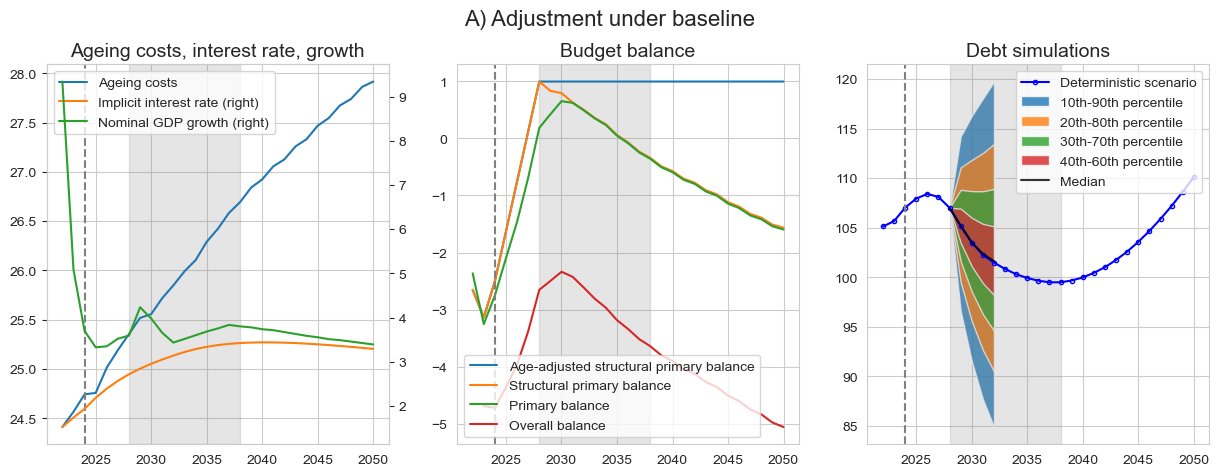

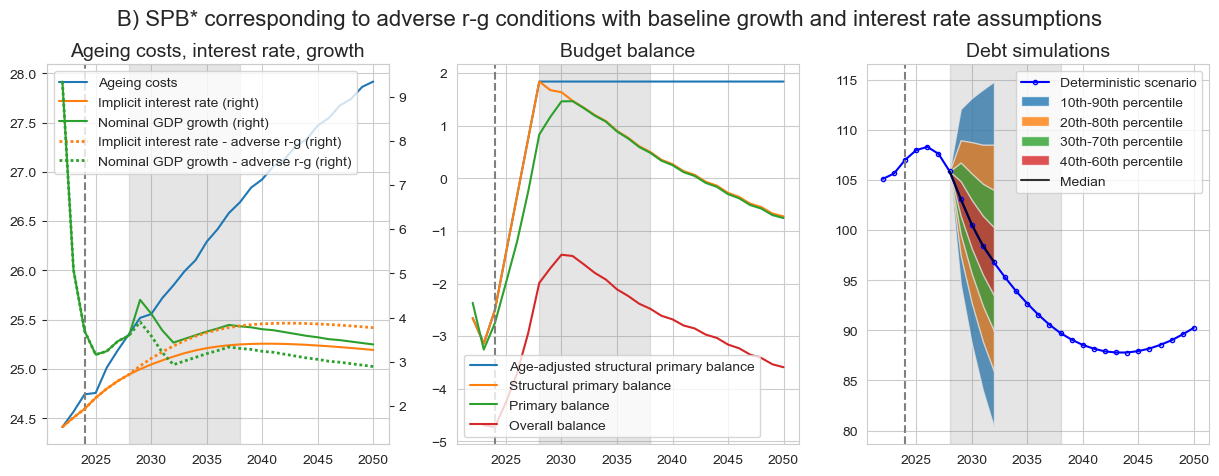

In [29]:
# Set color pallette
sns.set_palette(sns.color_palette('tab10'))
subtitle_size = 14 
for scenario in bel_chart_dict.keys():
    if scenario == 'main_adjustment':
        figure_title = 'A) Adjustment under baseline'
    elif scenario == 'baseline_binding_spbstar':
        figure_title = 'B) SPB* corresponding to adverse r-g conditions with baseline growth and interest rate assumptions'
    
    # Make 1, 3 sublot with df_interest_ageing_growth, df_budget_balance, df_fanchart
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(figure_title, fontsize=16)

    ## Plot df_interest_ageing_growth
    axs[0].set_title('Ageing costs, interest rate, growth', fontsize=subtitle_size)
    df_interest_ageing_growth = bel_chart_dict[scenario]['df_interest_ageing_growth']
    colors = sns.color_palette("tab10")
    axs[0].plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Ageing costs'], label='Ageing costs', color=colors[0])
    axs1 = axs[0].twinx()  # Create a twin Axes for the secondary y-axis
    axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Implicit interest rate'], label='Implicit interest rate (right)', color=colors[1])
    axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Nominal GDP growth'], label='Nominal GDP growth (right)', color=colors[2])

    if scenario == 'baseline_binding_spbstar':
        axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Implicit interest rate - adverse r-g'], label='Implicit interest rate - adverse r-g (right)', ls=(0,(1,1)), lw=2, color=colors[1])
        axs1.plot(df_interest_ageing_growth.index, df_interest_ageing_growth['Nominal GDP growth - adverse r-g'], label='Nominal GDP growth - adverse r-g (right)', ls=(0,(1,1)), lw=2, color=colors[2])
    axs1.grid(None)

    lines, labels = axs[0].get_legend_handles_labels()
    lines1, labels1 = axs1.get_legend_handles_labels()
    axs[0].legend(lines + lines1, labels + labels1, loc='upper left')


    axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))



    # Plot df_budget_balance
    axs[1].set_title('Budget balance', fontsize = subtitle_size)
    df_budget_balance = bel_chart_dict[scenario]['df_budget_balance']
    df_budget_balance.plot(ax=axs[1])
    axs[1].legend(loc='best')

    # Plot df_fanchart
    df_fanchart = bel_chart_dict[scenario]['df_fanchart']

    # plot, fill between p10 & p90, p20 & p80, p40 & p60
    # plot p50
    # plot baseline
    axs[2].set_title('Debt simulations', fontsize = subtitle_size)
    axs[2].plot(df_fanchart.index, df_fanchart['baseline'], color='blue', marker='o', markerfacecolor='none', markersize=3, label='Deterministic scenario')
    try:
        axs[2].fill_between(df_fanchart.index, df_fanchart['p10'], df_fanchart['p90'], label='10th-90th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p20'], df_fanchart['p80'], label='20th-80th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p30'], df_fanchart['p70'], label='30th-70th percentile', alpha=0.8)
        axs[2].fill_between(df_fanchart.index, df_fanchart['p40'], df_fanchart['p60'], label='40th-60th percentile', alpha=0.8)
        axs[2].plot(df_fanchart.index, df_fanchart['p50'], color='black', alpha=0.8, label='Median')
    except:
        pass
    axs[2].legend(loc='upper right')

    # add grey fill for 10 year post adustment and delete x-axis label
    for i in range(3):
        axs[i].axvspan(df_fanchart.index[2+4], df_fanchart.index[12+4], alpha=0.2, color='grey')
        axs[i].axvline(df_fanchart.index[2], color='grey', linestyle='--', lw=1.5)
        axs[i].set_xlabel('')

    fig.subplots_adjust(top=0.87)

    # Export to jpeg
    plt.savefig(f'{output_path}/results_charts/fig2_BEL_4_{scenario}.jpeg', dpi=300, bbox_inches='tight')

## Annex figures

In [30]:
# Initialize chart_dict
chart_dict = {}

# 1) get df of binding scenario
for country, adjustment_period_dict in results_dict.items():
    chart_dict[country] = {}
    for adjustment_period, scenario_dict in adjustment_period_dict.items():
        chart_dict[country][adjustment_period] = {}
        
        if 'deficit_safeguard' in scenario_dict.keys():
            # Safe df for deficit safeguard scenario if defined
            df = results_dict[country][adjustment_period]['deficit_safeguard']['df'].reset_index()

            # Set deficit parameters
            spbstar = results_dict[country][adjustment_period]['deficit_safeguard']['spbstar']
            spb_deficit_period = results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_period']
            spb_deficit_step = results_dict[country][adjustment_period]['deficit_safeguard']['spb_deficit_step']
        
        else:
            try:
                # Safe df for baseline binding scenario
                df = results_dict[country][adjustment_period]['baseline_binding_spbstar']['df'].reset_index()
            except:
                continue

            # Set deficit parameters to baseline
            spbstar = results_dict[country][adjustment_period]['baseline_binding_spbstar']['spbstar']
            spb_deficit_period = 0
            spb_deficit_step = 0.5

        # Create df for chart a)
        df_interest_ageing_growth = df[['y', 'iir', 'ageing_cost', 'ng']].rename(columns={'y': 'year', 'iir': 'Implicit interest rate', 'ng': 'Nominal GDP growth', 'ageing_cost':'Ageing costs'})
        df_interest_ageing_growth = df_interest_ageing_growth[['year', 'Ageing costs', 'Implicit interest rate', 'Nominal GDP growth']]
        chart_dict[country][adjustment_period]['df_interest_ageing_growth'] = df_interest_ageing_growth.set_index('year').loc[:2050]

        # Create df for chart b)
        df_budget_balance = df[['y', 'spb_bcoa', 'pb', 'fb', 'ageing_component']].rename(columns={'y': 'year', 'spb_bcoa': 'Age-adjusted structural primary balance', 'pb': 'Primary balance', 'fb': 'Overall balance'})
        df_budget_balance['Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'] + df_budget_balance['ageing_component'] 
        df_budget_balance.drop('ageing_component', axis=1, inplace=True)
        df_budget_balance.loc[:1+adjustment_period, 'Structural primary balance'] = df_budget_balance['Age-adjusted structural primary balance'].iloc[:2+adjustment_period]
        
        df_budget_balance = df_budget_balance[['year', 'Age-adjusted structural primary balance', 'Structural primary balance', 'Primary balance', 'Overall balance']]
        chart_dict[country][adjustment_period]['df_budget_balance'] = df_budget_balance.set_index('year').loc[:2050]

        # Run fanchart for chart c)
        try:
            if country == 'BGR':
                raise Exception('BGR has no viable fanchart because of restricted sample period')
            dsa = EcStochasticModel(country=country, adjustment_period=adjustment_period)
            dsa.project(spb_target=spbstar, spb_deficit_period=spb_deficit_period, spb_deficit_step=spb_deficit_step)
            dsa.simulate()
            dsa.fanchart(save_df=True, show=False)
            df_fanchart = dsa.df_fanchart
            df_fanchart.loc[2+adjustment_period+6:, 'p10':'p90'] = np.nan
            chart_dict[country][adjustment_period]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]
        except:
            df_fanchart = pd.DataFrame(columns=['year', 'baseline', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90'])
            df_fanchart['year'] = df['y']
            df_fanchart['baseline'] = df['d']
            chart_dict[country][adjustment_period]['df_fanchart'] = df_fanchart.set_index('year').loc[:2050]


In [31]:
# Set color pallette
sns.set_palette(sns.color_palette('tab10'))
subtitle_size = 14 
for country in chart_dict.keys():
    for adjustment_period in chart_dict[country].keys():
        
        try:
            # Make 1, 3 sublot with df_interest_ageing_growth, df_budget_balance, df_fanchart
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'{eu_code_dict[country]}: {adjustment_period}-year scenario', fontsize=16)

            # Plot df_interest_ageing_growth
            axs[0].set_title('Ageing costs, interest rate, growth', fontsize = subtitle_size)
            df_interest_ageing_growth = chart_dict[country][adjustment_period]['df_interest_ageing_growth']
            df_interest_ageing_growth.plot(ax=axs[0], secondary_y=['Implicit interest rate', 'Nominal GDP growth'])
            axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            lines = axs[0].get_lines() + axs[0].right_ax.get_lines()
            axs[0].legend(lines, [l.get_label() for l in lines], loc='best')


            # Plot df_budget_balance
            axs[1].set_title('Budget balance', fontsize = subtitle_size)
            df_budget_balance = chart_dict[country][adjustment_period]['df_budget_balance']
            df_budget_balance.plot(ax=axs[1])
            axs[1].legend(loc='best')

            # Plot df_fanchart
            df_fanchart = chart_dict[country][adjustment_period]['df_fanchart']
            axs[2].set_title('Debt simulations', fontsize = subtitle_size)
            axs[2].plot(df_fanchart.index, df_fanchart['baseline'], color='blue', marker='o', markerfacecolor='none', markersize=3, label='Deterministic scenario')
            try:
                axs[2].fill_between(df_fanchart.index, df_fanchart['p10'], df_fanchart['p90'], label='10th-90th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p20'], df_fanchart['p80'], label='20th-80th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p30'], df_fanchart['p70'], label='30th-70th percentile', alpha=0.8)
                axs[2].fill_between(df_fanchart.index, df_fanchart['p40'], df_fanchart['p60'], label='40th-60th percentile', alpha=0.8)
                axs[2].plot(df_fanchart.index, df_fanchart['p50'], color='black', alpha=0.8, label='Median')
            except:
                pass
            axs[2].legend(loc='upper right')

            # add grey fill for 10 year post adustment and delete x-axis label
            for i in range(3):
                axs[i].axvspan(df_fanchart.index[2+adjustment_period], df_fanchart.index[12+adjustment_period], alpha=0.2, color='grey')
                axs[i].axvline(df_fanchart.index[2], color='grey', linestyle='--', lw=1.5)
                axs[i].set_xlabel('')
            
            # Increase space between subplots and heading
            fig.subplots_adjust(top=0.87)

            # Export to jpeg
            plt.savefig(f'{output_path}/results_charts/{country}_{adjustment_period}.jpeg', dpi=300, bbox_inches='tight')
            plt.close()
        except:
            print(f'Error: {country}_{adjustment_period}')
            plt.close()